,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TrainSplit
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,True
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,True
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,True
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,True
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,True



Train Accuracy: 0.8961
Validation Accuracy: 0.8547

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       105
           1       0.82      0.84      0.83        74

    accuracy                           0.85       179
   macro avg       0.85      0.85      0.85       179
weighted avg       0.86      0.85      0.86       179



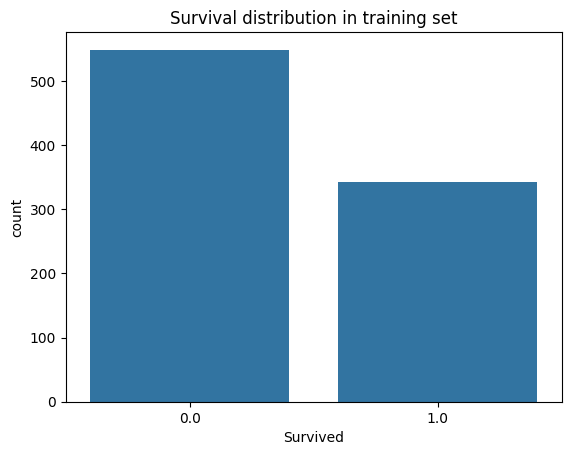

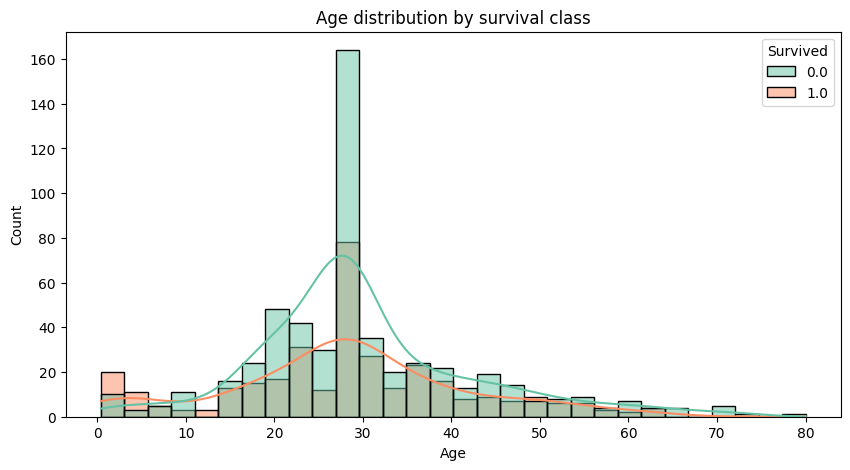

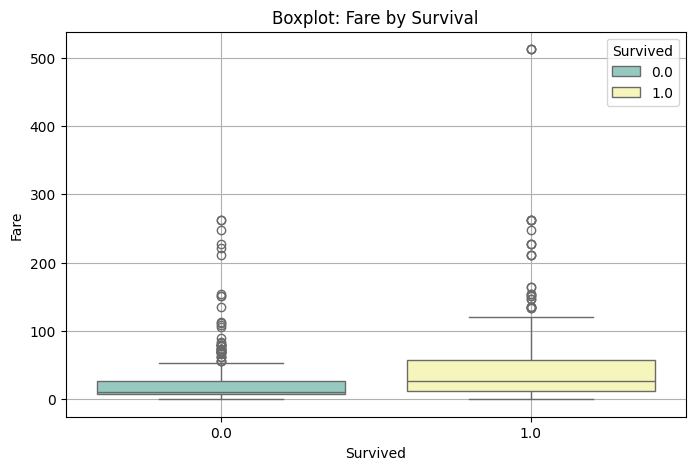

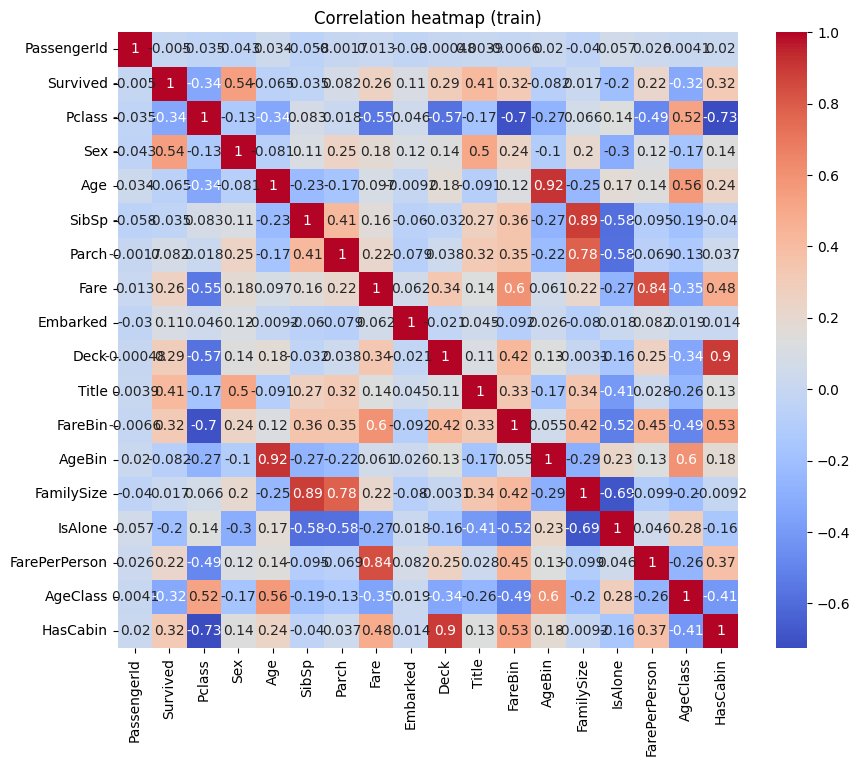

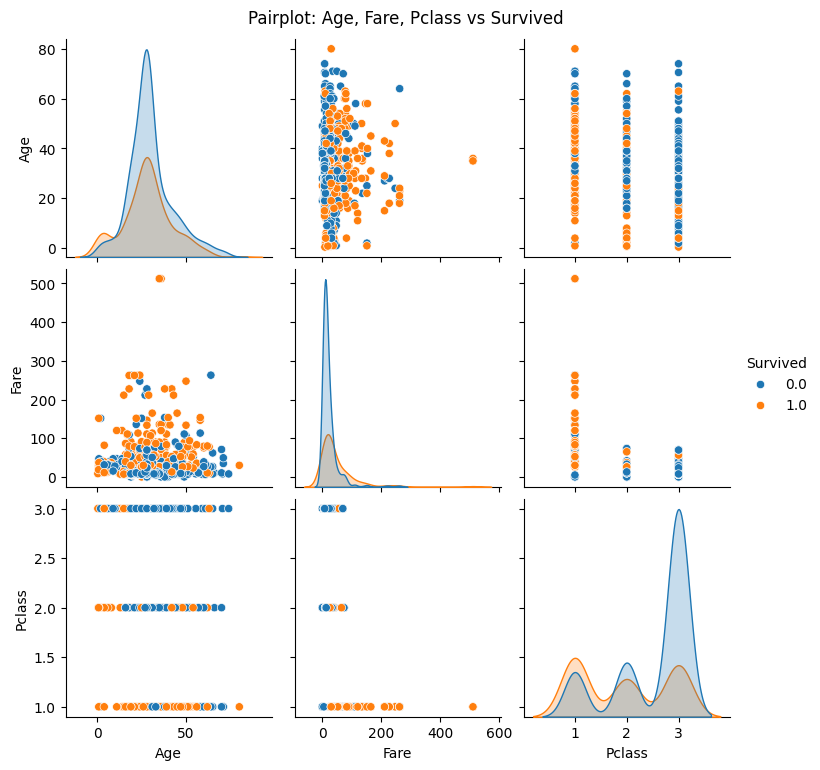

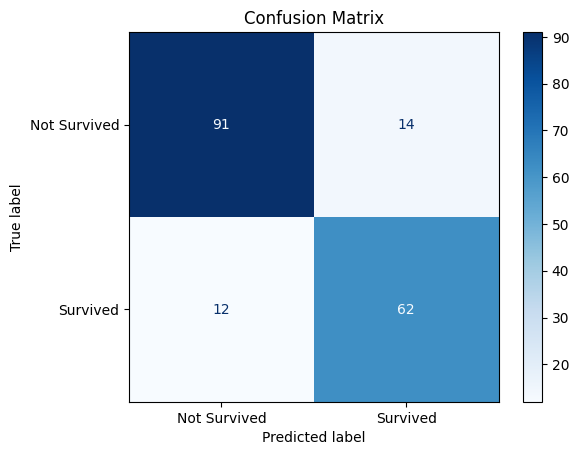

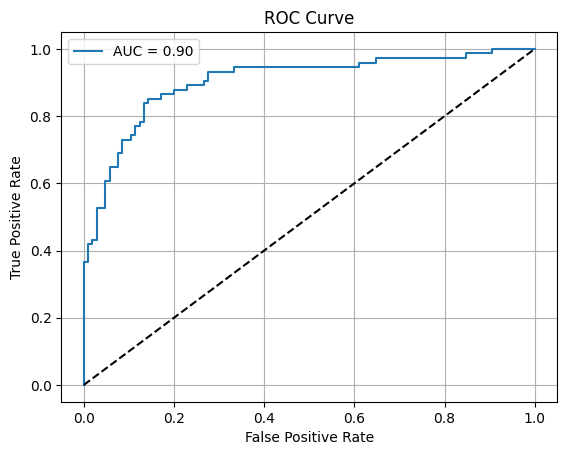

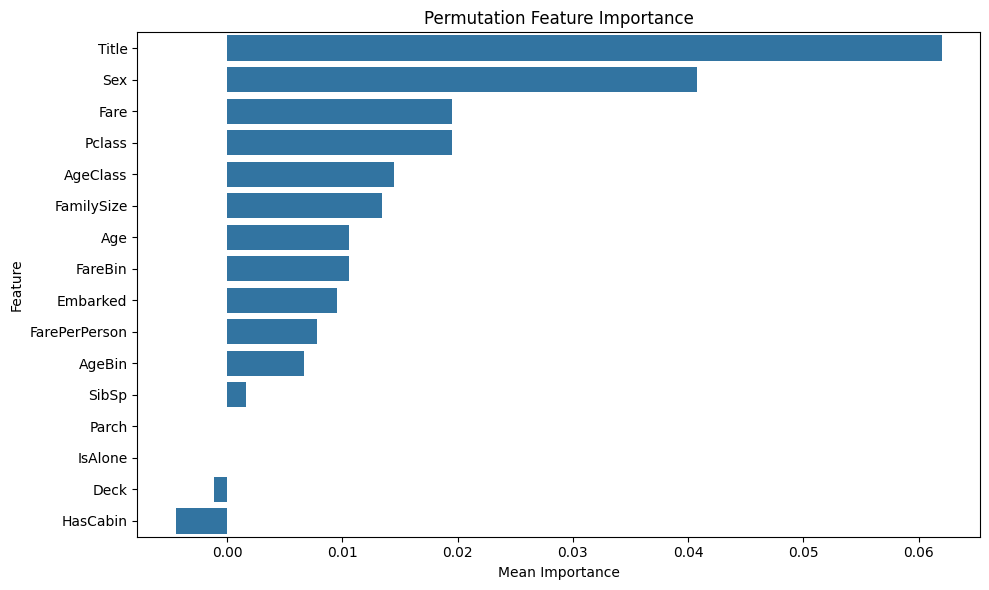

,precision,recall,f1-score,support
0,0.88,0.87,0.88,105.00
1,0.82,0.84,0.83,74.00
accuracy,0.85,0.85,0.85,0.85
macro avg,0.85,0.85,0.85,179.00
weighted avg,0.86,0.85,0.86,179.00


In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance

# Load data
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
test_df["Survived"] = np.nan
train_df["TrainSplit"] = True
test_df["TrainSplit"] = False
df = pd.concat([train_df, test_df], axis=0)

# Preview data
display(df.head())

# Preprocessing function
def preprocess_df(df):
    # Fill missing Cabin and extract Deck letter
    df['Cabin'] = df['Cabin'].fillna("U0")
    df['Deck'] = df['Cabin'].str.extract(r'([A-Za-z])', expand=False)
    deck_map = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8, 'U':0}
    df['Deck'] = df['Deck'].map(deck_map).fillna(0).astype(int)

    # Extract Title from Name
    df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace({
        'Mlle':'Miss', 'Ms':'Miss', 'Mme':'Mrs', 
        'Lady':'Rare', 'Countess':'Rare', 'Capt':'Rare', 'Col':'Rare',
        'Don':'Rare', 'Dr':'Rare', 'Major':'Rare', 'Rev':'Rare',
        'Sir':'Rare', 'Jonkheer':'Rare', 'Dona':'Rare'
    })
    title_map = {'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Rare':5}
    df['Title'] = df['Title'].map(title_map).fillna(6).astype(int)

    # Sex encoding
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

    # Embarked
    most_common_embarked = df['Embarked'].mode()[0]
    df['Embarked'] = df['Embarked'].fillna(most_common_embarked)
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

    # Fare and binning
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['FareBin'] = pd.qcut(df['Fare'], 5, labels=False).astype(int)

    # Age and binning
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['AgeBin'] = pd.cut(df['Age'], bins=[0, 12, 18, 25, 35, 60, 80], labels=False).astype(int)

    # Family size & IsAlone
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # Additional features
    df['FarePerPerson'] = (df['Fare'] / df['FamilySize']).fillna(0)
    df['AgeClass'] = df['Age'] * df['Pclass']
    df['HasCabin'] = (df['Cabin'] != "U0").astype(int)

    return df

df = preprocess_df(df)

# Split features and labels
df_model = df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin", "TrainSplit"])
df_train = df_model[df_model["Survived"].notna()]
df_test = df_model[df_model["Survived"].isna()].drop(columns=["Survived"])
X = df_train.drop(columns=["Survived"])
y = df_train["Survived"].astype(int)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model with RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [6, 9, 12, 15],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['sqrt'],
    'class_weight': ['balanced'],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=75,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=0,
    random_state=42
)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# Evaluation
y_pred = best_model.predict(X_val)
print(f"\nTrain Accuracy: {best_model.score(X_train, y_train):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Visualizations
sns.countplot(x='Survived', data=df[df["TrainSplit"]==True])
plt.title("Survival distribution in training set")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(data=df[df["TrainSplit"]==True], x='Age', hue='Survived', bins=30, kde=True, palette='Set2')
plt.title("Age distribution by survival class")
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=df[df["TrainSplit"]==True], x='Survived', y='Fare', hue='Survived', palette='Set3')
plt.title("Boxplot: Fare by Survival")
plt.ylabel("Fare")
plt.grid(True)
plt.legend(title="Survived", loc='upper right')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df[df["TrainSplit"]==True].select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation heatmap (train)")
plt.show()

sns.pairplot(df[df["TrainSplit"]==True][["Age", "Fare", "Pclass", "Survived"]], hue="Survived")
plt.suptitle("Pairplot: Age, Fare, Pclass vs Survived", y=1.02)
plt.show()

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Survived', 'Survived'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ROC curve
y_proba = best_model.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_proba)
auc = roc_auc_score(y_val, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# Permutation importance
result = permutation_importance(best_model, X_val, y_val, n_repeats=10, random_state=42)
importances = pd.DataFrame({
    'Feature': X_val.columns,
    'ImportanceMean': result.importances_mean,
    'ImportanceSTD': result.importances_std
}).sort_values(by='ImportanceMean', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=importances, x='ImportanceMean', y='Feature')  # no palette
plt.title("Permutation Feature Importance")
plt.xlabel("Mean Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Classification report as a table
report_df = pd.DataFrame(classification_report(y_val, y_pred, output_dict=True)).transpose()
display(report_df.round(2))